Setting up reddit API using praw

In [ ]:
import praw
import pandas as pd
from textblob import TextBlob
import yfinance as yf
from datetime import datetime, timedelta
import snowflake.connector

from dotenv import load_dotenv
import os



load_dotenv()
reddit = praw.Reddit(
    client_id=os.getenv('REDDIT_CLIENT_ID'),
    client_secret=os.getenv('REDDIT_CLIENT_SECRET'),
    user_agent=os.getenv('REDDIT_USER_AGENT')
)


Getting hot/top posts from r/CryptoCurrency and r/bitcoin

In [72]:
import pandas as pd
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def fetch_posts(subreddit_name, limit=100):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    for post in subreddit.hot(limit=limit):
        sentiment = analyzer.polarity_scores(post.title + " " + (post.selftext or ""))
        posts.append({
            'subreddit': subreddit_name,
            'title': post.title,
            'score': post.score,
            'comments': post.num_comments,
            'created_utc': datetime.utcfromtimestamp(post.created_utc),
            'sentiment': sentiment['compound']
        })
    return pd.DataFrame(posts)

df_crypto = fetch_posts('CryptoCurrency')
df_bitcoin = fetch_posts('bitcoin')

df_all = pd.concat([df_crypto, df_bitcoin])
df_all['sentiment_class'] = df_all['sentiment'].apply(lambda x: 'positive' if x > 0.2 else 'negative' if x < -0.2 else 'neutral')



/var/folders/j4/94cr8gn16cjf0bwfn812nf5r0000gn/T/ipykernel_49404/1485747408.py:17: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  'created_utc': datetime.utcfromtimestamp(post.created_utc),


Popular crypto on Reddit based on past weeks posts

/var/folders/j4/94cr8gn16cjf0bwfn812nf5r0000gn/T/ipykernel_49404/751639385.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  one_week_ago = datetime.utcnow() - timedelta(days=7)
/var/folders/j4/94cr8gn16cjf0bwfn812nf5r0000gn/T/ipykernel_49404/751639385.py:29: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if datetime.utcfromtimestamp(post.created_utc) >= one_week_ago:
/var/folders/j4/94cr8gn16cjf0bwfn812nf5r0000gn/T/ipykernel_49404/751639385.py:33: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fr

mention_count Counter({'bitcoin': 125, 'ethereum': 47, 'btc': 43, 'solana': 19, 'eth': 17, 'xrp': 9, 'cardano': 8, 'sol': 6, 'polygon': 3, 'ada': 2, 'doge': 2})


/var/folders/j4/94cr8gn16cjf0bwfn812nf5r0000gn/T/ipykernel_49404/751639385.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mention_df.head(10), x="Mentions", y="Coin", palette="viridis")


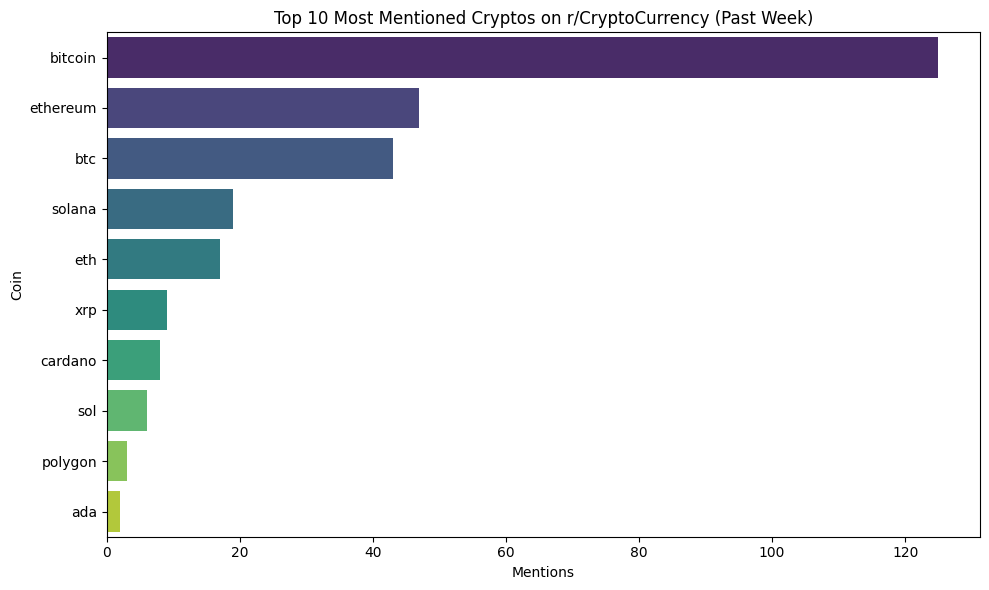

In [ ]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Timeframe
one_week_ago = datetime.utcnow() - timedelta(days=7)

# Fetch posts
subreddit = reddit.subreddit("CryptoCurrency")
posts = []
for post in subreddit.top(time_filter="week", limit=1000):
    if datetime.utcfromtimestamp(post.created_utc) >= one_week_ago:
        posts.append({
            "title": post.title,
            "selftext": post.selftext,
            "created": datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d'),
            "score": post.score,
            "num_comments": post.num_comments
        })

df = pd.DataFrame(posts)

# Crypto keyword match
keywords = ["BTC", "Bitcoin", "ETH", "Ethereum", "SOL", "Solana", "DOGE", "Dogecoin", 
            "ADA", "Cardano", "XRP", "AVAX", "DOT", "SHIB", "MATIC", "Polygon"]
pattern = r"\b(" + "|".join(re.escape(word.lower()) for word in keywords) + r")\b"
df["combined_text"] = (df["title"] + " " + df["selftext"]).str.lower()

# Count mentions
all_mentions = []
for text in df["combined_text"]:
    mentions = re.findall(pattern, text)
    all_mentions.extend(mentions)

mention_counts = Counter(all_mentions)
mention_df = pd.DataFrame(mention_counts.items(), columns=["Coin", "Mentions"]).sort_values(by="Mentions", ascending=False)
print("mention_count",mention_counts)
mention_df.to_csv("crypto_popularity.csv", index=False)
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=mention_df.head(10), x="Mentions", y="Coin", palette="viridis")
plt.title("Top 10 Most Mentioned Cryptos on r/CryptoCurrency (Past Week)")
plt.xlabel("Mentions")
plt.ylabel("Coin")
plt.tight_layout()
plt.show()


Bitcoin price analysis vs reddit sentiment

In [41]:
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=60)
posts = []

for post in reddit.subreddit("bitcoin").top(time_filter="month", limit=500):
    created = datetime.utcfromtimestamp(post.created_utc)
    if created >= start_date:
        posts.append({
            "date": created.date(),
            "title": post.title,
            "selftext": post.selftext
        })

reddit_df = pd.DataFrame(posts)
reddit_df

/var/folders/j4/94cr8gn16cjf0bwfn812nf5r0000gn/T/ipykernel_49404/2248496210.py:1: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow()
/var/folders/j4/94cr8gn16cjf0bwfn812nf5r0000gn/T/ipykernel_49404/2248496210.py:6: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  created = datetime.utcfromtimestamp(post.created_utc)


,date,title,selftext
0,2025-04-25,11 years ago...,# A legend was born\n\nThis guy is a legend.\n...
1,2025-04-28,"$1,400 Stimulus Check is Now Worth $22K",
2,2025-04-23,This guy was mining 1 Bitcoin per day in 2011 😲,
3,2025-05-14,Just in: Bitcoin 200k this year confirmed!,
4,2025-04-22,THIS...,# No one wants this to happen to them\n\nThis ...
...,...,...,...
495,2025-05-13,Lightning fixes this ⚡️,
496,2025-05-03,Bitaxe ⚡️ Bitcoin miner cooled by the water of...,
497,2025-04-23,Bitcoin is the Future,
498,2025-05-19,Out the way old man.,


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd

# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Apply FinBERT to analyze sentiment
def analyze_sentiment_finbert(text):
    result = finbert_pipeline(text[:512])[0]  # truncate to 512 tokens for model input
    return result['label'], result['score']

# Assuming reddit_df is already defined with a 'combined_text' column
reddit_df[["sentiment_class", "sentiment_score"]] = reddit_df["title"].apply(lambda x: pd.Series(analyze_sentiment_finbert(x)))
# Drop unwanted columns
reddit_df.drop(columns=["selftext", "combined_text"], inplace=True, errors='ignore')

# Save cleaned CSV
reddit_df.to_csv("btc_price_data.csv", index=False)

reddit_df





Device set to use mps:0


,date,title,sentiment_class,sentiment_score
0,2025-04-25,11 years ago...,Neutral,0.999707
1,2025-04-28,"$1,400 Stimulus Check is Now Worth $22K",Neutral,0.999979
2,2025-04-23,This guy was mining 1 Bitcoin per day in 2011 😲,Neutral,0.999976
3,2025-05-14,Just in: Bitcoin 200k this year confirmed!,Neutral,0.999772
4,2025-04-22,THIS...,Neutral,0.993564
...,...,...,...,...
495,2025-05-13,Lightning fixes this ⚡️,Neutral,0.914040
496,2025-05-03,Bitaxe ⚡️ Bitcoin miner cooled by the water of...,Neutral,0.999951
497,2025-04-23,Bitcoin is the Future,Neutral,0.997954
498,2025-05-19,Out the way old man.,Neutral,0.990821


In [55]:
import requests
import pandas as pd
from datetime import datetime

# Request 60 days of daily prices for Bitcoin in USD
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {
    "vs_currency": "usd",
    "days": "60",         # You can also use 'max' for all-time data
    "interval": "daily"
}

response = requests.get(url, params=params)
data = response.json()

# Convert price data
prices = data["prices"]  # List of [timestamp, price]

price_df = pd.DataFrame(prices, columns=["timestamp", "price_usd"])
price_df["date"] = pd.to_datetime(price_df["timestamp"], unit='ms').dt.date
price_df = price_df.drop(columns="timestamp")

print(price_df)
price_df.to_csv("btc_price_data.csv",index=False)

        price_usd        date
0    85787.709149  2025-03-24
1    87327.729697  2025-03-25
2    87520.583915  2025-03-26
3    86960.855549  2025-03-27
4    87227.271580  2025-03-28
..            ...         ...
56  106030.637683  2025-05-19
57  105629.415804  2025-05-20
58  106786.719958  2025-05-21
59  109665.863716  2025-05-22
60  110722.145571  2025-05-22

[61 rows x 2 columns]


Bitcoin 24hr volume vs reddit sentiment

In [65]:
import requests
import pandas as pd
from datetime import datetime

# Request 60 days of daily prices for Bitcoin in USD
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {
    "vs_currency": "usd",
    "days": "60",         # You can also use 'max' for all-time data
    "interval": "daily"
}

response = requests.get(url, params=params)
data = response.json()
# Extract volume data
volumes = data["total_volumes"]  # List of [timestamp, volume]

# Format to DataFrame
volume_df = pd.DataFrame(volumes, columns=["timestamp", "volume_usd"])
volume_df["date"] = pd.to_datetime(volume_df["timestamp"], unit="ms").dt.date
volume_df["volume_usd"] = volume_df["volume_usd"].astype("float64").round(0).astype("int64")
volume_df = volume_df.drop(columns="timestamp")

print(volume_df)

     volume_usd        date
0   12617587531  2025-03-24
1   27270889835  2025-03-25
2   30351832943  2025-03-26
3   25522877559  2025-03-27
4   24620445368  2025-03-28
..          ...         ...
56  30744060180  2025-05-19
57  43339734154  2025-05-20
58  36393687094  2025-05-21
59  60722883114  2025-05-22
60  72355409072  2025-05-22

[61 rows x 2 columns]


In [ ]:
volume_merged_df=pd.merge(reddit_df,volume_df,on="date",how="inner")
volume_merged_df.to_csv("btc_sentiment_volume.csv",index=False)
print("volume data saved")

volume data saved


In [ ]:
merged_df = pd.merge(reddit_df, price_df, on="date", how="inner")
merged_df.to_csv("btc_sentiment_price.csv", index=False)
print("price data saved")


500

Connecting and uploading data to snowflake

In [ ]:
import snowflake.connector
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()

# Load your CSV
df = pd.read_csv("btc_sentiment_price.csv")


# Snowflake connection info
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT'), # e.g. abcde-xy12345
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database=os.getenv('SNOWFLAKE_DATABASE'),
    schema=os.getenv('SNOWFLAKE_SCHEMA')
)

In [13]:
create_table_query = """
CREATE OR REPLACE TABLE BTC_SENTIMENT_PRICE (
    date DATE,
    title STRING,
    selftext STRING,
    combined_text STRING,
    sentiment_class STRING,
    sentiment_score FLOAT,
    price_usd FLOAT
);
"""

cursor = conn.cursor()
cursor.execute(create_table_query)
cursor.close()


True

In [ ]:
# Step 1: Upload file to internal stage (e.g., table stage)
cursor = conn.cursor()
cursor.execute("""
    PUT file://btc_sentiment_price.csv @%BTC_SENTIMENT_PRICE OVERWRITE = TRUE
""")

# Step 2: Copy data into the table
cursor.execute("""
    COPY INTO BTC_SENTIMENT_PRICE
    FROM @%BTC_SENTIMENT_PRICE
    FILE_FORMAT = (TYPE = CSV FIELD_OPTIONALLY_ENCLOSED_BY = '"' SKIP_HEADER = 1)
""")

cursor.close()
conn.close()

In [27]:
create_table_query = """
CREATE OR REPLACE TABLE CRYPTO_POPULARITY (
    COIN STRING,
    MENTIONS INT
);
"""

cursor = conn.cursor()
cursor.execute(create_table_query)


In [ ]:
import snowflake.connector
from dotenv import load_dotenv
import os


# Step 1: Upload file to internal stage
cursor.execute("""
    PUT file://crypto_popularity.csv @%CRYPTO_POPULARITY OVERWRITE = TRUE
""")

# Step 2: Copy data from staged file to table
cursor.execute("""
    COPY INTO CRYPTO_POPULARITY
    FROM @%CRYPTO_POPULARITY
    FILE_FORMAT = (TYPE = CSV FIELD_OPTIONALLY_ENCLOSED_BY = '"' SKIP_HEADER = 1)
""")

cursor.close()
conn.close()
print("crypto_popularity.csv uploaded to Snowflake!")


✅ crypto_popularity.csv uploaded to Snowflake!
